In [24]:
import tensorflow as tf
import tensorflow_datasets as tfds

In [25]:
datos, metadatos = tfds.load('mnist', as_supervised=True, with_info=True)

In [26]:
datos_entrenamiento, datos_test = datos['train'], datos['test']

In [27]:
metadatos

tfds.core.DatasetInfo(
    name='mnist',
    full_name='mnist/3.0.1',
    description="""
    The MNIST database of handwritten digits.
    """,
    homepage='http://yann.lecun.com/exdb/mnist/',
    data_dir='/home/jovyan/tensorflow_datasets/mnist/3.0.1',
    file_format=tfrecord,
    download_size=11.06 MiB,
    dataset_size=21.00 MiB,
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=60000, num_shards=1>,
    },
    citation="""@article{lecun2010mnist,
      title={MNIST handwritten digit database},
      author={LeCun, Yann and Cortes, Corinna and Burges, CJ},
      journal={ATT Labs [Online]. Available: http://yann.lecun.com/exdb/mnist},
      volume={2},
      year={2010}
    }""",
)

In [28]:
nombre_clases = metadatos.features['label'].names
nombre_clases

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

In [29]:
def normalizer(imagenes, etiquetas):
  imagenes = tf.cast(imagenes, tf.float32)
  imagenes /= 255
  return imagenes, etiquetas

# Normalizamos los datos
datos_entrenamiento = datos_entrenamiento.map(normalizer)
datos_test = datos_test.map(normalizer)

2024-06-26 15:12:33.568490: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


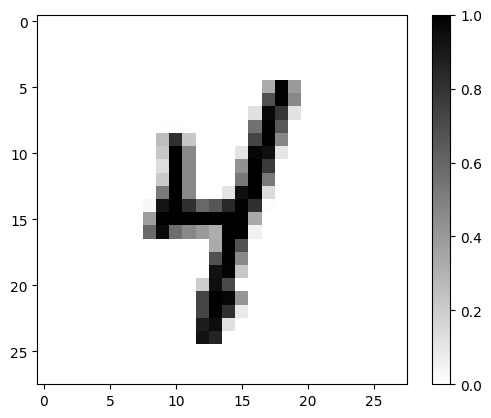

In [30]:
for imagen, etiqueta in datos_entrenamiento.take(1):
  break
imagen = imagen.numpy().reshape((28,28)) # Redimensiona

import matplotlib.pyplot as plt

plt.figure()
plt.imshow(imagen, cmap=plt.cm.binary)
plt.colorbar()
plt.grid(False)
plt.show()

2024-06-26 15:12:34.039513: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-06-26 15:12:34.054139: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


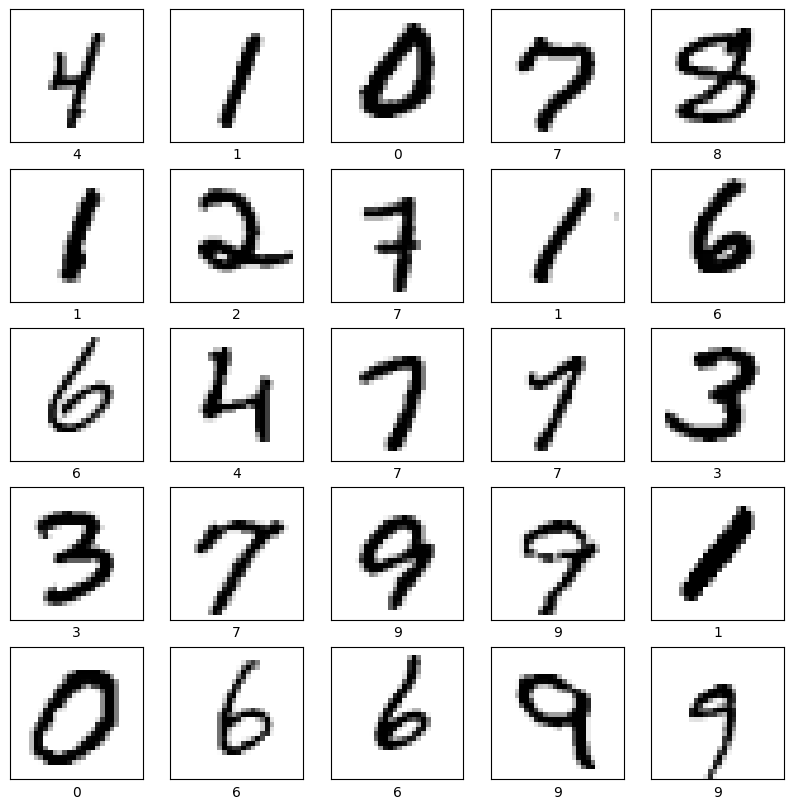

In [31]:
plt.figure(figsize=(10,10))
for i, (imagen, etiqueta) in enumerate(datos_entrenamiento.take(25)):
  imagen = imagen.numpy().reshape((28,28))
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(imagen, cmap=plt.cm.binary)
  plt.xlabel(nombre_clases[etiqueta])
plt.show()

In [32]:
num_ej_entrenamiento = metadatos.splits["train"].num_examples
num_ej_pruebas = metadatos.splits["test"].num_examples
print(num_ej_entrenamiento)
print(num_ej_pruebas)

60000
10000


In [33]:
modelo = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), input_shape=(28,28,1), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2), #2,2 es el tamano de la matriz

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2), #2,2 es el tamano de la matriz

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=100, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

#Compilar el modelo
modelo.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

/opt/conda/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [34]:
#Los numeros de datos de entrenamiento y pruebas (60k y 10k)
num_datos_entrenamiento = metadatos.splits["train"].num_examples
num_datos_pruebas = metadatos.splits["test"].num_examples

#Trabajar por lotes
TAMANO_LOTE=32

#Shuffle y repeat hacen que los datos esten mezclados de manera aleatoria
#para que el entrenamiento no se aprenda las cosas en orden
datos_entrenamiento = datos_entrenamiento.repeat().shuffle(num_datos_entrenamiento).batch(TAMANO_LOTE)
datos_pruebas = datos_test.batch(TAMANO_LOTE)

In [35]:
#Realizar el entrenamiento
import math

historial = modelo.fit(
    datos_entrenamiento,
    epochs=3,
    steps_per_epoch=math.ceil(num_datos_entrenamiento/TAMANO_LOTE)
)

Epoch 1/3
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 24s 11ms/step - accuracy: 0.9080 - loss: 0.3007
Epoch 2/3
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 20s 10ms/step - accuracy: 0.9855 - loss: 0.0466
Epoch 3/3
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 19s 10ms/step - accuracy: 0.9903 - loss: 0.0304


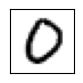

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediccion: 0


In [54]:
import numpy as np
#Probar una imagen suelta
for imagen, etiqueta in datos_entrenamiento.take(1):
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(imagen[0], cmap=plt.cm.binary)
  plt.show()
  break



imagen = tf.expand_dims(imagen[0], axis=0)
# Al añadir lotes de datos para entrenar "modelo", la variable imagen contiene el número de lote (un conjunto de imágenes). 
# Por tanto, la imagen de datos_entrenamiento que se añade a imagen debe tener también el numero de 
# lote de formq eu quede p.e. (1, 28, 28, 1) 
# (donde 1 es el tamaño del lote, # 28x28 son las dimensiones de la imagen y 1 es el canal de color
# para imágenes en escala de grises).

# Por tanto imagen[0] toma la primera imagen del lote y se añade la dimensión del lote: 
# tf.expand_dims(imagen[0], axis=0) añadiendo una dimensión adicional al principio

prediccion = modelo.predict(imagen)

print("Prediccion: " + nombre_clases[np.argmax(prediccion[0])])

In [ ]:
# Exportacion del modelo a h5
# modelo.save('numeros_conv.h5')